In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
df = pd.read_csv("dataset/Mall_customers.csv")

In [84]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [86]:
unique = df['Gender'].unique()
to_int = {date: i for i, date in enumerate(unique)}
df['Gender'] = df['Gender'].map(to_int)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


In [88]:
df_train = df.iloc[:150 , :]
df_test = df.iloc[150: , :]

In [89]:
X_train = df_train.iloc[:, 2:4].values
X_test = df_test.iloc[:, 2:4].values

In [90]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, random_state=None, init='k-means++'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.init = init

    def _initialize_centroids_kmeans_pp(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        centroids = np.empty((self.n_clusters, n_features), dtype=X.dtype)
        first_idx = np.random.choice(n_samples)
        centroids[0] = X[first_idx]
        
        closest_dist_sq = np.full(n_samples, np.inf)
        
        for c_id in range(1, self.n_clusters):
            dist_to_new_centroid = np.linalg.norm(X - centroids[c_id-1], axis=1) ** 2
            closest_dist_sq = np.minimum(closest_dist_sq, dist_to_new_centroid)
            
            probabilities = closest_dist_sq / closest_dist_sq.sum()
            next_idx = np.random.choice(n_samples, p=probabilities)
            centroids[c_id] = X[next_idx]
        
        return centroids

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
    
        self._store_X(X)  # store X for inertia
    
        np.random.seed(self.random_state)
        
        if self.init == 'k-means++':
            self.centroids = self._initialize_centroids_kmeans_pp(X)
        else:
            initial_centroid_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.centroids = X[initial_centroid_indices]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            new_centroids = np.array([
                X[labels == i].mean(axis=0) if len(X[labels == i]) > 0 else self.centroids[i]
                for i in range(self.n_clusters)
            ])

            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            
            self.centroids = new_centroids
        
        self.labels_ = labels

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

    def cluster_centers_(self):
        return self.centroids

    @property
    def inertia_(self):
        if self.centroids is None or self.labels_ is None:
            raise ValueError("Model has not been fitted yet.")
        wcss = 0.0
        for i in range(self.n_clusters):
            cluster_points = self.X[self.labels_ == i]
            if len(cluster_points) > 0:
                distances = np.linalg.norm(cluster_points - self.centroids[i], axis=1)
                wcss += np.sum(distances ** 2)
        return wcss

    def _store_X(self, X):
        # Internal helper to store X for inertia calculation
        self.X = X


In [91]:
wcss = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_train)
    print(f'Clusters: {i}, WCSS: {kmeans.inertia_}')
    wcss.append(kmeans.inertia_)

Clusters: 1, WCSS: 85591.52
Clusters: 2, WCSS: 58955.53995601172
Clusters: 3, WCSS: 26511.982258482258
Clusters: 4, WCSS: 21405.414522469397
Clusters: 5, WCSS: 16387.234126984127
Clusters: 6, WCSS: 12354.613266968263
Clusters: 7, WCSS: 12049.956951469583
Clusters: 8, WCSS: 12196.40198801743
Clusters: 9, WCSS: 9270.047201336676


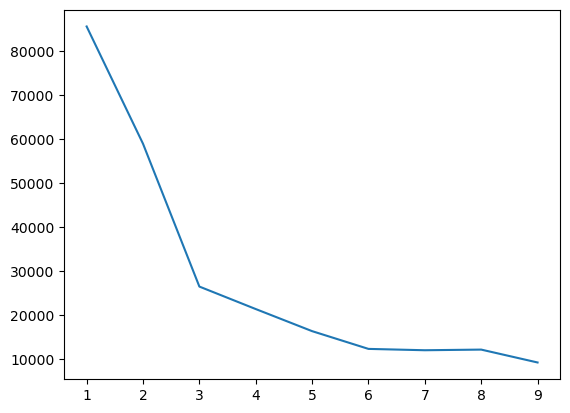

In [92]:
plt.plot(range(1, 10), wcss)
plt.show()

In [93]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
kmeans.fit(X_train)

In [94]:
print(kmeans.cluster_centers_())

[[64.63157895 54.68421053]
 [45.32258065 64.09677419]
 [27.43478261 21.        ]
 [25.96774194 68.77419355]
 [25.71428571 42.52380952]
 [51.8        35.28      ]]


In [95]:
y_pred = kmeans.predict(X_test)

In [96]:
y_pred

array([1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3], dtype=int64)

In [97]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

In [81]:
print("Accuracy:", accuracy(y_test, y_pred))
print("Precision:", precision(y_test, y_pred))
print("Recall:", recall(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

NameError: name 'y_test' is not defined